# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

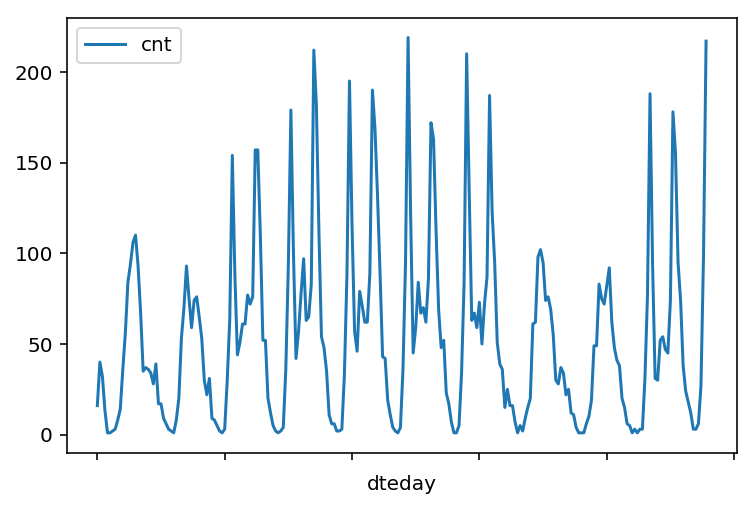

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [7]:
data.head(2)

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,...,0,0,0,0,0,0,0,0,0,1


### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [8]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [9]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [10]:
#############
# In the my_answers.py file, fill out the TODO sections as specified
#############
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from my_answers import NeuralNetwork

In [11]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [12]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.029s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, this process can have sharply diminishing returns and can waste computational resources if you use too many iterations.  You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. The ideal number of iterations would be a level that stops shortly after the validation loss is no longer decreasing.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. Normally a good choice to start at is 0.1; however, if you effectively divide the learning rate by n_records, try starting out with a learning rate of 1. In either case, if the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
In a model where all the weights are optimized, the more hidden nodes you have, the more accurate the predictions of the model will be.  (A fully optimized model could have weights of zero, after all.) However, the more hidden nodes you have, the harder it will be to optimize the weights of the model, and the more likely it will be that suboptimal weights will lead to overfitting. With overfitting, the model will memorize the training data instead of learning the true pattern, and won't generalize well to unseen data.  

Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.  You'll generally find that the best number of hidden nodes to use ends up being between the number of input and output nodes.

In [15]:
import sys
from my_answers import iterations, learning_rate, hidden_nodes, output_nodes
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from my_answers import NeuralNetwork

#temp	hum	windspeed

#train_features = train_features[['temp','hum','windspeed']] 
#val_features = val_features[['temp','hum','windspeed']] 

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)
####################
### Set the hyperparameters in you myanswers.py file ###
####################

#from my_answers import iterations, learning_rate, hidden_nodes, output_nodes


#N_i = train_features.shape[1]
#network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    print  ("\n \n \n iterations",ii)
    # Go through a random batch of 128 records from the training data set
    #batch = np.random.choice(train_features.index, size=128)
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
    #print (X[0:3], y[0:3])                         
    network.train(X, y)
    
    # Printing out the training progress
    #print ("train_targets  sasasa", train_targets['cnt'])
    train_loss = MSE(network.run(train_features).T, [train_targets['cnt']])
    
    val_loss = MSE(network.run(val_features).T,[val_targets['cnt']] )
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

 
 
 iterations 0
Progress: 0.0% ... Training loss: 1.016 ... Validation loss: 1.278
 
 
 iterations 1
Progress: 0.1% ... Training loss: 0.976 ... Validation loss: 1.567
 
 
 iterations 2
Progress: 0.1% ... Training loss: 1.092 ... Validation loss: 1.261
 
 
 iterations 3
Progress: 0.1% ... Training loss: 1.703 ... Validation loss: 2.799
 
 
 iterations 4
Progress: 0.2% ... Training loss: 2.216 ... Validation loss: 1.981
 
 
 iterations 5
Progress: 0.2% ... Training loss: 3.900 ... Validation loss: 5.727
 
 
 iterations 6
Progress: 0.3% ... Training loss: 6.522 ... Validation loss: 5.680
 
 
 iterations 7
Progress: 0.3% ... Training loss: 4.919 ... Validation loss: 6.677
 
 
 iterations 8
Progress: 0.4% ... Training loss: 1.163 ... Validation loss: 1.249
 
 
 iterations 9
Progress: 0.5% ... Training loss: 0.820 ... Validation loss: 1.349
 
 
 iterations 10
Progress: 0.5% ... Training loss: 0.796 ..

Progress: 4.7% ... Training loss: 0.343 ... Validation loss: 0.550
 
 
 iterations 95
Progress: 4.8% ... Training loss: 0.339 ... Validation loss: 0.542
 
 
 iterations 96
Progress: 4.8% ... Training loss: 0.339 ... Validation loss: 0.549
 
 
 iterations 97
Progress: 4.8% ... Training loss: 0.339 ... Validation loss: 0.558
 
 
 iterations 98
Progress: 4.9% ... Training loss: 0.332 ... Validation loss: 0.541
 
 
 iterations 99
Progress: 5.0% ... Training loss: 0.333 ... Validation loss: 0.539
 
 
 iterations 100
Progress: 5.0% ... Training loss: 0.343 ... Validation loss: 0.533
 
 
 iterations 101
Progress: 5.0% ... Training loss: 0.332 ... Validation loss: 0.529
 
 
 iterations 102
Progress: 5.1% ... Training loss: 0.332 ... Validation loss: 0.519
 
 
 iterations 103
Progress: 5.2% ... Training loss: 0.327 ... Validation loss: 0.525
 
 
 iterations 104
Progress: 5.2% ... Training loss: 0.321 ... Validation loss: 0.521
 
 
 iterations 105
Progress: 5.2% ... Training loss: 0.318 ... Vali

Progress: 9.4% ... Training loss: 0.269 ... Validation loss: 0.449
 
 
 iterations 189
Progress: 9.4% ... Training loss: 0.267 ... Validation loss: 0.441
 
 
 iterations 190
Progress: 9.5% ... Training loss: 0.278 ... Validation loss: 0.451
 
 
 iterations 191
Progress: 9.6% ... Training loss: 0.269 ... Validation loss: 0.437
 
 
 iterations 192
Progress: 9.6% ... Training loss: 0.265 ... Validation loss: 0.431
 
 
 iterations 193
Progress: 9.7% ... Training loss: 0.267 ... Validation loss: 0.433
 
 
 iterations 194
Progress: 9.7% ... Training loss: 0.268 ... Validation loss: 0.430
 
 
 iterations 195
Progress: 9.8% ... Training loss: 0.278 ... Validation loss: 0.466
 
 
 iterations 196
Progress: 9.8% ... Training loss: 0.266 ... Validation loss: 0.434
 
 
 iterations 197
Progress: 9.8% ... Training loss: 0.285 ... Validation loss: 0.456
 
 
 iterations 198
Progress: 9.9% ... Training loss: 0.291 ... Validation loss: 0.437
 
 
 iterations 199
Progress: 9.9% ... Training loss: 0.295 ...

Progress: 14.1% ... Training loss: 0.281 ... Validation loss: 0.423
 
 
 iterations 282
Progress: 14.1% ... Training loss: 0.270 ... Validation loss: 0.446
 
 
 iterations 283
Progress: 14.2% ... Training loss: 0.302 ... Validation loss: 0.416
 
 
 iterations 284
Progress: 14.2% ... Training loss: 0.326 ... Validation loss: 0.507
 
 
 iterations 285
Progress: 14.2% ... Training loss: 0.271 ... Validation loss: 0.425
 
 
 iterations 286
Progress: 14.3% ... Training loss: 0.253 ... Validation loss: 0.420
 
 
 iterations 287
Progress: 14.3% ... Training loss: 0.256 ... Validation loss: 0.417
 
 
 iterations 288
Progress: 14.4% ... Training loss: 0.253 ... Validation loss: 0.426
 
 
 iterations 289
Progress: 14.4% ... Training loss: 0.290 ... Validation loss: 0.463
 
 
 iterations 290
Progress: 14.5% ... Training loss: 0.271 ... Validation loss: 0.448
 
 
 iterations 291
Progress: 14.6% ... Training loss: 0.255 ... Validation loss: 0.428
 
 
 iterations 292
Progress: 14.6% ... Training los

Progress: 18.7% ... Training loss: 0.242 ... Validation loss: 0.403
 
 
 iterations 375
Progress: 18.8% ... Training loss: 0.241 ... Validation loss: 0.400
 
 
 iterations 376
Progress: 18.8% ... Training loss: 0.277 ... Validation loss: 0.420
 
 
 iterations 377
Progress: 18.9% ... Training loss: 0.256 ... Validation loss: 0.412
 
 
 iterations 378
Progress: 18.9% ... Training loss: 0.256 ... Validation loss: 0.416
 
 
 iterations 379
Progress: 18.9% ... Training loss: 0.258 ... Validation loss: 0.414
 
 
 iterations 380
Progress: 19.0% ... Training loss: 0.283 ... Validation loss: 0.439
 
 
 iterations 381
Progress: 19.1% ... Training loss: 0.294 ... Validation loss: 0.436
 
 
 iterations 382
Progress: 19.1% ... Training loss: 0.242 ... Validation loss: 0.400
 
 
 iterations 383
Progress: 19.1% ... Training loss: 0.246 ... Validation loss: 0.403
 
 
 iterations 384
Progress: 19.2% ... Training loss: 0.241 ... Validation loss: 0.398
 
 
 iterations 385
Progress: 19.2% ... Training los

Progress: 23.4% ... Training loss: 0.228 ... Validation loss: 0.385
 
 
 iterations 468
Progress: 23.4% ... Training loss: 0.227 ... Validation loss: 0.376
 
 
 iterations 469
Progress: 23.4% ... Training loss: 0.243 ... Validation loss: 0.384
 
 
 iterations 470
Progress: 23.5% ... Training loss: 0.237 ... Validation loss: 0.394
 
 
 iterations 471
Progress: 23.6% ... Training loss: 0.231 ... Validation loss: 0.376
 
 
 iterations 472
Progress: 23.6% ... Training loss: 0.226 ... Validation loss: 0.376
 
 
 iterations 473
Progress: 23.6% ... Training loss: 0.232 ... Validation loss: 0.376
 
 
 iterations 474
Progress: 23.7% ... Training loss: 0.229 ... Validation loss: 0.388
 
 
 iterations 475
Progress: 23.8% ... Training loss: 0.229 ... Validation loss: 0.377
 
 
 iterations 476
Progress: 23.8% ... Training loss: 0.228 ... Validation loss: 0.381
 
 
 iterations 477
Progress: 23.9% ... Training loss: 0.229 ... Validation loss: 0.386
 
 
 iterations 478
Progress: 23.9% ... Training los

Progress: 28.0% ... Training loss: 0.221 ... Validation loss: 0.403
 
 
 iterations 561
Progress: 28.1% ... Training loss: 0.249 ... Validation loss: 0.397
 
 
 iterations 562
Progress: 28.1% ... Training loss: 0.217 ... Validation loss: 0.378
 
 
 iterations 563
Progress: 28.1% ... Training loss: 0.237 ... Validation loss: 0.393
 
 
 iterations 564
Progress: 28.2% ... Training loss: 0.215 ... Validation loss: 0.391
 
 
 iterations 565
Progress: 28.2% ... Training loss: 0.239 ... Validation loss: 0.398
 
 
 iterations 566
Progress: 28.3% ... Training loss: 0.214 ... Validation loss: 0.373
 
 
 iterations 567
Progress: 28.4% ... Training loss: 0.218 ... Validation loss: 0.376
 
 
 iterations 568
Progress: 28.4% ... Training loss: 0.213 ... Validation loss: 0.381
 
 
 iterations 569
Progress: 28.4% ... Training loss: 0.217 ... Validation loss: 0.378
 
 
 iterations 570
Progress: 28.5% ... Training loss: 0.226 ... Validation loss: 0.401
 
 
 iterations 571
Progress: 28.6% ... Training los

Progress: 32.6% ... Training loss: 0.206 ... Validation loss: 0.357
 
 
 iterations 654
Progress: 32.7% ... Training loss: 0.208 ... Validation loss: 0.359
 
 
 iterations 655
Progress: 32.8% ... Training loss: 0.201 ... Validation loss: 0.362
 
 
 iterations 656
Progress: 32.8% ... Training loss: 0.202 ... Validation loss: 0.359
 
 
 iterations 657
Progress: 32.9% ... Training loss: 0.203 ... Validation loss: 0.354
 
 
 iterations 658
Progress: 32.9% ... Training loss: 0.204 ... Validation loss: 0.359
 
 
 iterations 659
Progress: 33.0% ... Training loss: 0.203 ... Validation loss: 0.363
 
 
 iterations 660
Progress: 33.0% ... Training loss: 0.207 ... Validation loss: 0.373
 
 
 iterations 661
Progress: 33.0% ... Training loss: 0.213 ... Validation loss: 0.364
 
 
 iterations 662
Progress: 33.1% ... Training loss: 0.222 ... Validation loss: 0.370
 
 
 iterations 663
Progress: 33.1% ... Training loss: 0.202 ... Validation loss: 0.363
 
 
 iterations 664
Progress: 33.2% ... Training los

Progress: 37.3% ... Training loss: 0.185 ... Validation loss: 0.346
 
 
 iterations 747
Progress: 37.4% ... Training loss: 0.186 ... Validation loss: 0.352
 
 
 iterations 748
Progress: 37.4% ... Training loss: 0.196 ... Validation loss: 0.404
 
 
 iterations 749
Progress: 37.5% ... Training loss: 0.190 ... Validation loss: 0.337
 
 
 iterations 750
Progress: 37.5% ... Training loss: 0.183 ... Validation loss: 0.347
 
 
 iterations 751
Progress: 37.5% ... Training loss: 0.185 ... Validation loss: 0.335
 
 
 iterations 752
Progress: 37.6% ... Training loss: 0.182 ... Validation loss: 0.346
 
 
 iterations 753
Progress: 37.6% ... Training loss: 0.185 ... Validation loss: 0.347
 
 
 iterations 754
Progress: 37.7% ... Training loss: 0.183 ... Validation loss: 0.358
 
 
 iterations 755
Progress: 37.8% ... Training loss: 0.183 ... Validation loss: 0.344
 
 
 iterations 756
Progress: 37.8% ... Training loss: 0.188 ... Validation loss: 0.334
 
 
 iterations 757
Progress: 37.9% ... Training los

Progress: 42.0% ... Training loss: 0.176 ... Validation loss: 0.322
 
 
 iterations 840
Progress: 42.0% ... Training loss: 0.173 ... Validation loss: 0.338
 
 
 iterations 841
Progress: 42.0% ... Training loss: 0.177 ... Validation loss: 0.318
 
 
 iterations 842
Progress: 42.1% ... Training loss: 0.184 ... Validation loss: 0.358
 
 
 iterations 843
Progress: 42.1% ... Training loss: 0.177 ... Validation loss: 0.332
 
 
 iterations 844
Progress: 42.2% ... Training loss: 0.183 ... Validation loss: 0.378
 
 
 iterations 845
Progress: 42.2% ... Training loss: 0.166 ... Validation loss: 0.323
 
 
 iterations 846
Progress: 42.3% ... Training loss: 0.185 ... Validation loss: 0.351
 
 
 iterations 847
Progress: 42.4% ... Training loss: 0.172 ... Validation loss: 0.315
 
 
 iterations 848
Progress: 42.4% ... Training loss: 0.164 ... Validation loss: 0.318
 
 
 iterations 849
Progress: 42.5% ... Training loss: 0.165 ... Validation loss: 0.314
 
 
 iterations 850
Progress: 42.5% ... Training los

Progress: 46.6% ... Training loss: 0.154 ... Validation loss: 0.301
 
 
 iterations 933
Progress: 46.6% ... Training loss: 0.155 ... Validation loss: 0.306
 
 
 iterations 934
Progress: 46.7% ... Training loss: 0.152 ... Validation loss: 0.296
 
 
 iterations 935
Progress: 46.8% ... Training loss: 0.152 ... Validation loss: 0.297
 
 
 iterations 936
Progress: 46.8% ... Training loss: 0.151 ... Validation loss: 0.304
 
 
 iterations 937
Progress: 46.9% ... Training loss: 0.153 ... Validation loss: 0.308
 
 
 iterations 938
Progress: 46.9% ... Training loss: 0.171 ... Validation loss: 0.300
 
 
 iterations 939
Progress: 47.0% ... Training loss: 0.155 ... Validation loss: 0.307
 
 
 iterations 940
Progress: 47.0% ... Training loss: 0.159 ... Validation loss: 0.303
 
 
 iterations 941
Progress: 47.0% ... Training loss: 0.155 ... Validation loss: 0.316
 
 
 iterations 942
Progress: 47.1% ... Training loss: 0.152 ... Validation loss: 0.298
 
 
 iterations 943
Progress: 47.1% ... Training los

Progress: 51.2% ... Training loss: 0.140 ... Validation loss: 0.295
 
 
 iterations 1026
Progress: 51.3% ... Training loss: 0.144 ... Validation loss: 0.283
 
 
 iterations 1027
Progress: 51.4% ... Training loss: 0.150 ... Validation loss: 0.335
 
 
 iterations 1028
Progress: 51.4% ... Training loss: 0.140 ... Validation loss: 0.278
 
 
 iterations 1029
Progress: 51.5% ... Training loss: 0.136 ... Validation loss: 0.280
 
 
 iterations 1030
Progress: 51.5% ... Training loss: 0.136 ... Validation loss: 0.285
 
 
 iterations 1031
Progress: 51.5% ... Training loss: 0.136 ... Validation loss: 0.280
 
 
 iterations 1032
Progress: 51.6% ... Training loss: 0.138 ... Validation loss: 0.285
 
 
 iterations 1033
Progress: 51.6% ... Training loss: 0.139 ... Validation loss: 0.273
 
 
 iterations 1034
Progress: 51.7% ... Training loss: 0.139 ... Validation loss: 0.279
 
 
 iterations 1035
Progress: 51.8% ... Training loss: 0.137 ... Validation loss: 0.267
 
 
 iterations 1036
Progress: 51.8% ... T

Progress: 55.9% ... Training loss: 0.128 ... Validation loss: 0.257
 
 
 iterations 1118
Progress: 55.9% ... Training loss: 0.128 ... Validation loss: 0.256
 
 
 iterations 1119
Progress: 56.0% ... Training loss: 0.137 ... Validation loss: 0.269
 
 
 iterations 1120
Progress: 56.0% ... Training loss: 0.140 ... Validation loss: 0.265
 
 
 iterations 1121
Progress: 56.0% ... Training loss: 0.136 ... Validation loss: 0.269
 
 
 iterations 1122
Progress: 56.1% ... Training loss: 0.127 ... Validation loss: 0.261
 
 
 iterations 1123
Progress: 56.1% ... Training loss: 0.125 ... Validation loss: 0.274
 
 
 iterations 1124
Progress: 56.2% ... Training loss: 0.125 ... Validation loss: 0.274
 
 
 iterations 1125
Progress: 56.2% ... Training loss: 0.128 ... Validation loss: 0.280
 
 
 iterations 1126
Progress: 56.3% ... Training loss: 0.134 ... Validation loss: 0.269
 
 
 iterations 1127
Progress: 56.4% ... Training loss: 0.128 ... Validation loss: 0.285
 
 
 iterations 1128
Progress: 56.4% ... T

Progress: 60.5% ... Training loss: 0.121 ... Validation loss: 0.251
 
 
 iterations 1210
Progress: 60.5% ... Training loss: 0.122 ... Validation loss: 0.271
 
 
 iterations 1211
Progress: 60.5% ... Training loss: 0.121 ... Validation loss: 0.248
 
 
 iterations 1212
Progress: 60.6% ... Training loss: 0.137 ... Validation loss: 0.260
 
 
 iterations 1213
Progress: 60.6% ... Training loss: 0.118 ... Validation loss: 0.254
 
 
 iterations 1214
Progress: 60.7% ... Training loss: 0.127 ... Validation loss: 0.258
 
 
 iterations 1215
Progress: 60.8% ... Training loss: 0.116 ... Validation loss: 0.251
 
 
 iterations 1216
Progress: 60.8% ... Training loss: 0.117 ... Validation loss: 0.253
 
 
 iterations 1217
Progress: 60.9% ... Training loss: 0.117 ... Validation loss: 0.269
 
 
 iterations 1218
Progress: 60.9% ... Training loss: 0.116 ... Validation loss: 0.252
 
 
 iterations 1219
Progress: 61.0% ... Training loss: 0.123 ... Validation loss: 0.261
 
 
 iterations 1220
Progress: 61.0% ... T

Progress: 65.0% ... Training loss: 0.111 ... Validation loss: 0.233
 
 
 iterations 1302
Progress: 65.1% ... Training loss: 0.107 ... Validation loss: 0.226
 
 
 iterations 1303
Progress: 65.2% ... Training loss: 0.109 ... Validation loss: 0.229
 
 
 iterations 1304
Progress: 65.2% ... Training loss: 0.115 ... Validation loss: 0.227
 
 
 iterations 1305
Progress: 65.2% ... Training loss: 0.118 ... Validation loss: 0.244
 
 
 iterations 1306
Progress: 65.3% ... Training loss: 0.113 ... Validation loss: 0.223
 
 
 iterations 1307
Progress: 65.3% ... Training loss: 0.115 ... Validation loss: 0.238
 
 
 iterations 1308
Progress: 65.4% ... Training loss: 0.106 ... Validation loss: 0.226
 
 
 iterations 1309
Progress: 65.5% ... Training loss: 0.112 ... Validation loss: 0.226
 
 
 iterations 1310
Progress: 65.5% ... Training loss: 0.105 ... Validation loss: 0.224
 
 
 iterations 1311
Progress: 65.5% ... Training loss: 0.110 ... Validation loss: 0.219
 
 
 iterations 1312
Progress: 65.6% ... T

Progress: 69.7% ... Training loss: 0.103 ... Validation loss: 0.224
 
 
 iterations 1394
Progress: 69.7% ... Training loss: 0.102 ... Validation loss: 0.233
 
 
 iterations 1395
Progress: 69.8% ... Training loss: 0.102 ... Validation loss: 0.230
 
 
 iterations 1396
Progress: 69.8% ... Training loss: 0.103 ... Validation loss: 0.225
 
 
 iterations 1397
Progress: 69.8% ... Training loss: 0.099 ... Validation loss: 0.236
 
 
 iterations 1398
Progress: 69.9% ... Training loss: 0.106 ... Validation loss: 0.230
 
 
 iterations 1399
Progress: 70.0% ... Training loss: 0.100 ... Validation loss: 0.243
 
 
 iterations 1400
Progress: 70.0% ... Training loss: 0.097 ... Validation loss: 0.225
 
 
 iterations 1401
Progress: 70.0% ... Training loss: 0.099 ... Validation loss: 0.215
 
 
 iterations 1402
Progress: 70.1% ... Training loss: 0.099 ... Validation loss: 0.218
 
 
 iterations 1403
Progress: 70.2% ... Training loss: 0.101 ... Validation loss: 0.216
 
 
 iterations 1404
Progress: 70.2% ... T

Progress: 74.2% ... Training loss: 0.092 ... Validation loss: 0.188
 
 
 iterations 1486
Progress: 74.3% ... Training loss: 0.096 ... Validation loss: 0.191
 
 
 iterations 1487
Progress: 74.3% ... Training loss: 0.098 ... Validation loss: 0.202
 
 
 iterations 1488
Progress: 74.4% ... Training loss: 0.093 ... Validation loss: 0.199
 
 
 iterations 1489
Progress: 74.5% ... Training loss: 0.092 ... Validation loss: 0.193
 
 
 iterations 1490
Progress: 74.5% ... Training loss: 0.091 ... Validation loss: 0.196
 
 
 iterations 1491
Progress: 74.5% ... Training loss: 0.091 ... Validation loss: 0.199
 
 
 iterations 1492
Progress: 74.6% ... Training loss: 0.092 ... Validation loss: 0.195
 
 
 iterations 1493
Progress: 74.7% ... Training loss: 0.094 ... Validation loss: 0.199
 
 
 iterations 1494
Progress: 74.7% ... Training loss: 0.094 ... Validation loss: 0.191
 
 
 iterations 1495
Progress: 74.8% ... Training loss: 0.097 ... Validation loss: 0.186
 
 
 iterations 1496
Progress: 74.8% ... T

Progress: 78.8% ... Training loss: 0.086 ... Validation loss: 0.196
 
 
 iterations 1578
Progress: 78.9% ... Training loss: 0.086 ... Validation loss: 0.206
 
 
 iterations 1579
Progress: 79.0% ... Training loss: 0.088 ... Validation loss: 0.197
 
 
 iterations 1580
Progress: 79.0% ... Training loss: 0.086 ... Validation loss: 0.190
 
 
 iterations 1581
Progress: 79.0% ... Training loss: 0.086 ... Validation loss: 0.195
 
 
 iterations 1582
Progress: 79.1% ... Training loss: 0.089 ... Validation loss: 0.188
 
 
 iterations 1583
Progress: 79.2% ... Training loss: 0.092 ... Validation loss: 0.199
 
 
 iterations 1584
Progress: 79.2% ... Training loss: 0.085 ... Validation loss: 0.191
 
 
 iterations 1585
Progress: 79.2% ... Training loss: 0.092 ... Validation loss: 0.200
 
 
 iterations 1586
Progress: 79.3% ... Training loss: 0.090 ... Validation loss: 0.185
 
 
 iterations 1587
Progress: 79.3% ... Training loss: 0.089 ... Validation loss: 0.214
 
 
 iterations 1588
Progress: 79.4% ... T

Progress: 83.5% ... Training loss: 0.084 ... Validation loss: 0.212
 
 
 iterations 1670
Progress: 83.5% ... Training loss: 0.088 ... Validation loss: 0.225
 
 
 iterations 1671
Progress: 83.5% ... Training loss: 0.080 ... Validation loss: 0.182
 
 
 iterations 1672
Progress: 83.6% ... Training loss: 0.080 ... Validation loss: 0.188
 
 
 iterations 1673
Progress: 83.7% ... Training loss: 0.083 ... Validation loss: 0.197
 
 
 iterations 1674
Progress: 83.7% ... Training loss: 0.085 ... Validation loss: 0.179
 
 
 iterations 1675
Progress: 83.8% ... Training loss: 0.095 ... Validation loss: 0.226
 
 
 iterations 1676
Progress: 83.8% ... Training loss: 0.085 ... Validation loss: 0.179
 
 
 iterations 1677
Progress: 83.8% ... Training loss: 0.082 ... Validation loss: 0.181
 
 
 iterations 1678
Progress: 83.9% ... Training loss: 0.081 ... Validation loss: 0.183
 
 
 iterations 1679
Progress: 84.0% ... Training loss: 0.083 ... Validation loss: 0.200
 
 
 iterations 1680
Progress: 84.0% ... T

Progress: 88.0% ... Training loss: 0.076 ... Validation loss: 0.174
 
 
 iterations 1762
Progress: 88.1% ... Training loss: 0.083 ... Validation loss: 0.175
 
 
 iterations 1763
Progress: 88.2% ... Training loss: 0.080 ... Validation loss: 0.189
 
 
 iterations 1764
Progress: 88.2% ... Training loss: 0.077 ... Validation loss: 0.173
 
 
 iterations 1765
Progress: 88.2% ... Training loss: 0.076 ... Validation loss: 0.171
 
 
 iterations 1766
Progress: 88.3% ... Training loss: 0.078 ... Validation loss: 0.172
 
 
 iterations 1767
Progress: 88.3% ... Training loss: 0.092 ... Validation loss: 0.165
 
 
 iterations 1768
Progress: 88.4% ... Training loss: 0.084 ... Validation loss: 0.192
 
 
 iterations 1769
Progress: 88.5% ... Training loss: 0.084 ... Validation loss: 0.173
 
 
 iterations 1770
Progress: 88.5% ... Training loss: 0.076 ... Validation loss: 0.182
 
 
 iterations 1771
Progress: 88.5% ... Training loss: 0.083 ... Validation loss: 0.198
 
 
 iterations 1772
Progress: 88.6% ... T

Progress: 92.7% ... Training loss: 0.101 ... Validation loss: 0.169
 
 
 iterations 1854
Progress: 92.7% ... Training loss: 0.126 ... Validation loss: 0.224
 
 
 iterations 1855
Progress: 92.8% ... Training loss: 0.096 ... Validation loss: 0.165
 
 
 iterations 1856
Progress: 92.8% ... Training loss: 0.083 ... Validation loss: 0.188
 
 
 iterations 1857
Progress: 92.8% ... Training loss: 0.087 ... Validation loss: 0.164
 
 
 iterations 1858
Progress: 92.9% ... Training loss: 0.100 ... Validation loss: 0.218
 
 
 iterations 1859
Progress: 93.0% ... Training loss: 0.085 ... Validation loss: 0.166
 
 
 iterations 1860
Progress: 93.0% ... Training loss: 0.079 ... Validation loss: 0.184
 
 
 iterations 1861
Progress: 93.0% ... Training loss: 0.083 ... Validation loss: 0.172
 
 
 iterations 1862
Progress: 93.1% ... Training loss: 0.083 ... Validation loss: 0.209
 
 
 iterations 1863
Progress: 93.2% ... Training loss: 0.074 ... Validation loss: 0.178
 
 
 iterations 1864
Progress: 93.2% ... T

Progress: 97.2% ... Training loss: 0.076 ... Validation loss: 0.156
 
 
 iterations 1946
Progress: 97.3% ... Training loss: 0.072 ... Validation loss: 0.163
 
 
 iterations 1947
Progress: 97.3% ... Training loss: 0.075 ... Validation loss: 0.164
 
 
 iterations 1948
Progress: 97.4% ... Training loss: 0.073 ... Validation loss: 0.181
 
 
 iterations 1949
Progress: 97.5% ... Training loss: 0.072 ... Validation loss: 0.176
 
 
 iterations 1950
Progress: 97.5% ... Training loss: 0.074 ... Validation loss: 0.166
 
 
 iterations 1951
Progress: 97.5% ... Training loss: 0.077 ... Validation loss: 0.159
 
 
 iterations 1952
Progress: 97.6% ... Training loss: 0.081 ... Validation loss: 0.167
 
 
 iterations 1953
Progress: 97.7% ... Training loss: 0.085 ... Validation loss: 0.156
 
 
 iterations 1954
Progress: 97.7% ... Training loss: 0.089 ... Validation loss: 0.187
 
 
 iterations 1955
Progress: 97.8% ... Training loss: 0.091 ... Validation loss: 0.158
 
 
 iterations 1956
Progress: 97.8% ... T

iterations = 800
learning_rate = .8
hidden_nodes = 10
output_nodes = 1

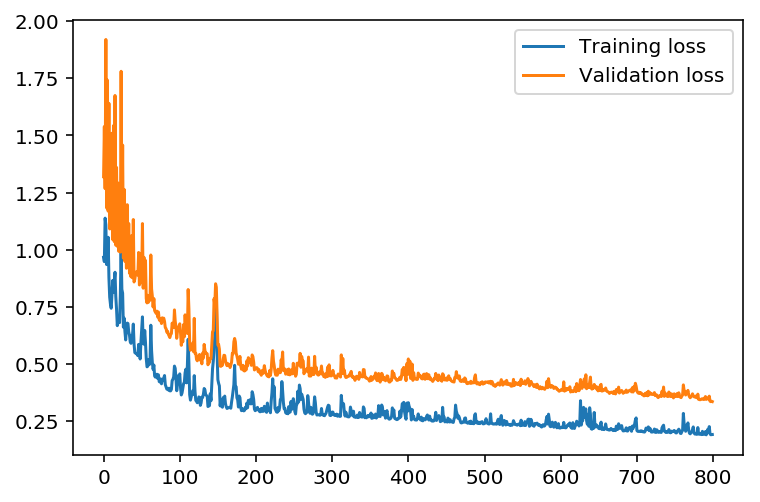

In [87]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

iterations = 600
learning_rate = 1
hidden_nodes = 10
output_nodes = 1


 iterations 599
Progress: 99.8% ... Training loss: 0.217 ... Validation loss: 0.391

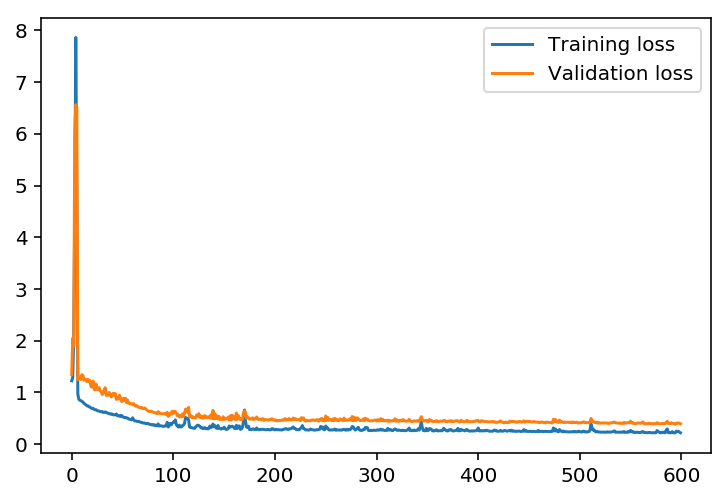

In [93]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

iterations = 2000
learning_rate = .1
hidden_nodes = 10
output_nodes = 1

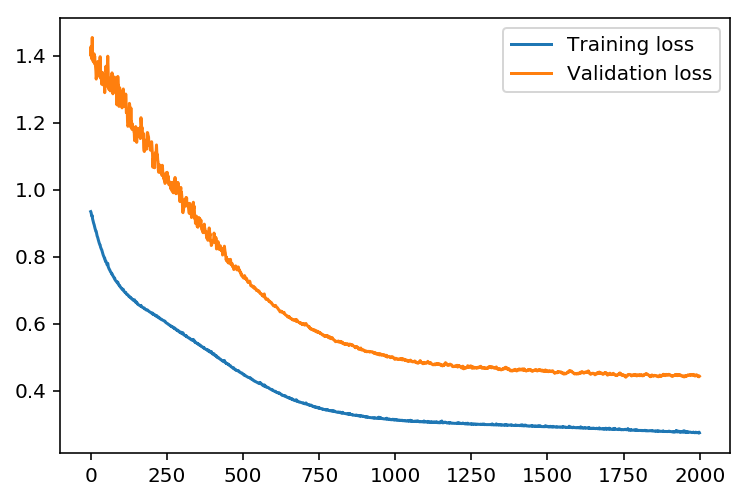

In [73]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

iterations = 600
learning_rate = 1
hidden_nodes = 10
output_nodes = 1

In [94]:


def MSE(y, Y):
    return np.mean((y-Y)**2)

test_loss = MSE(network.run(test_features).T,[test_targets['cnt']] )

test_loss


0.2741696183765438

iterations = 2000
learning_rate = 1
hidden_nodes = 10
output_nodes = 1


loss in test data 0.156018005031


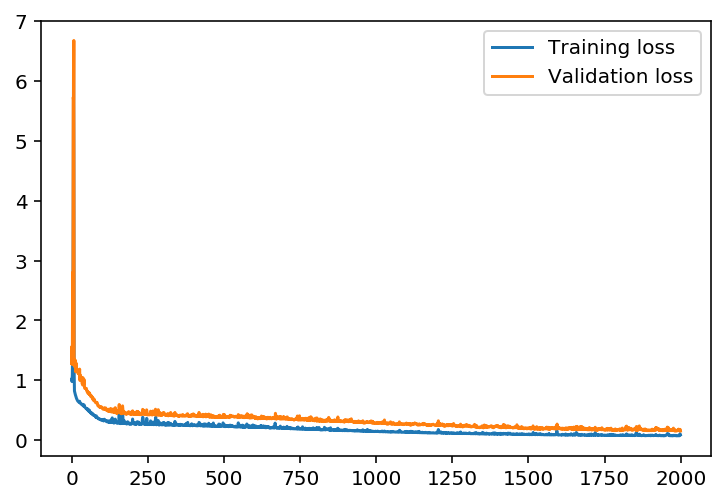

In [16]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

test_loss = MSE(network.run(test_features).T,[test_targets['cnt']] )

print ("loss in test data",test_loss)

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

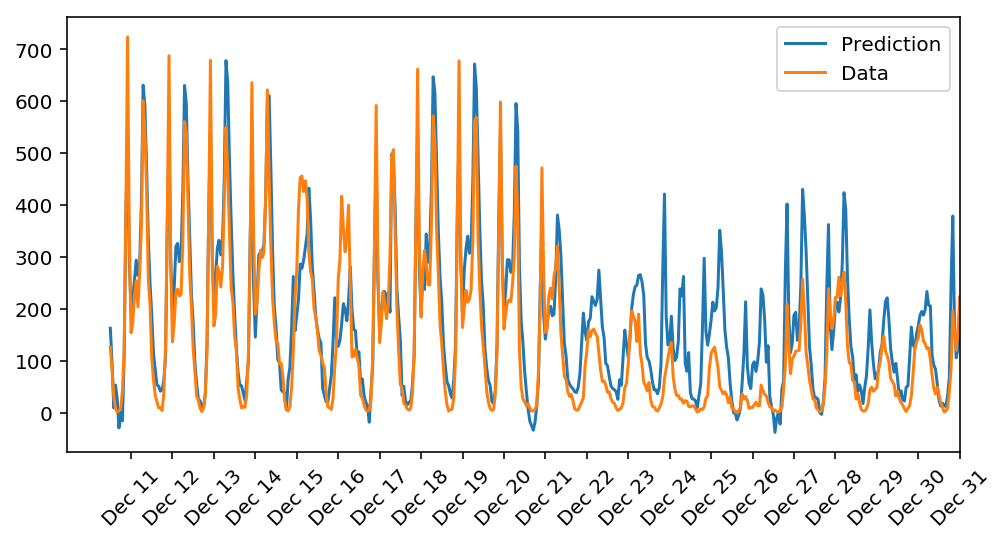

In [99]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below

Model predicted the data fairly well, test data have mse .15 . There seems some variations in actual and predicted last part of year . May be we need to train model including some details of how rentals effect with holidays i.e last part of year which is christmas new year time.